# TransactionSentinel: Proteção inteligente contra fraudes em transações de cartão de crédito.


* Este notebook apresenta a construção de um estudo e um modelo de ML para detecção de fraudes em dados financeiros fictícios, seguindo a metodologia CRISP-DM.

* A abordagem será estruturada em cinco das seis etapas da metodologia. A etapa de Deploy (Implantação) não será totalmente executada; no entanto, o modelo será salvo como se estivesse pronto para produção.
    * Etapas: 

        * **Compreensão do Negócio** – Definição do problema e dos objetivos do projeto.

        * **Compreensão dos Dados** – Exploração inicial para entender a estrutura e qualidade dos dados.

        * **Preparação dos Dados** – Tratamento, limpeza e transformação dos dados para a modelagem.

        * **Modelagem** – Aplicação de algoritmos de machine learning para detectar padrões de fraude.

        * **Avaliação** – Medição do desempenho do modelo para garantir sua eficácia.

        * **Deploy** (Implantação) – Integração do modelo em um ambiente operacional para uso real.

# 1.Compreensão do Negócio

* A detecção de fraudes em transações financeiras é um desafio essencial para instituições bancárias e operadoras de cartões de crédito. A identificação eficiente de fraudes reduz perdas financeiras e protege clientes contra atividades fraudulentas.

* Objetivo do Projeto:

    * 1- Desenvolver uma análise exploratória que forneça informações sobre o comportamento dos eventos fraudulentos e não fraudulentos. 

    * 2-Desenvolver um modelo de Machine Learning capaz de identificar transações fraudulentas com alto desempenho, garantindo um equilíbrio entre segurança e experiência do usuário.



        * O modelo será avaliado com as seguintes métricas:

        * **Recall ≥ 70% ** – Para minimizar a quantidade de fraudes não detectadas.

        * ** AUC-ROC ≥ 85% ** – Para garantir uma boa distinção entre transações legítimas e fraudulentas.

        * ** F1-score ≥ 74% ** – Para garantir um bom equilíbrio entre precisão e recall, considerando a importância de minimizar tanto os falsos positivos quanto os falsos negativos.

* Restrições de Negócio

    Para atender a requisitos e garantir um modelo confiável:

    * Imparcialidade e Prevenção de Discriminação: 
    
        O modelo não deve apresentar tendências discriminatórias baseadas em atributos como gênero, idade, localização ou outros fatores socioeconômicos. Se esse tipo de varivel for interessante ao evento em estudo, deve se aplicar transformacoes nessas variaveis para que seja mitigada chance de vies descriminativo, ex: idade pode ser transformada em faixas etarias, localizacao pode se tornar distancia entre residencia do titular e local do estabelecimento (verificando distancia de tempo entre duas ou mais transacoes) para identificar algum padrao nas fraudes. 

 


    * Explicabilidade e Transparência

        O modelo deve ser interpretável tanto globalmente quanto localmente, garantindo que especialistas possam entender seus critérios de decisão. Técnicas como SHAP (SHapley Additive Explanations) e LIME (Local Interpretable Model-agnostic Explanations) serão aplicadas para fornecer insights sobre as previsões do modelo.

* Escopo da Implantação
    * O modelo final será salvo para futuras implementações, mas a fase de Deploy não será completamente executada neste estudo.



# 2.Compreensão dos Dados

In [1]:
#Bibliotecas
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import warnings
from scipy.stats import chi2_contingency
import plotly.express as px
import plotly.graph_objects as go

* Importando e conhecendo os dados inicialmente

In [2]:
############para Kaggle

# Load the training dataset
#train_data = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv') 

# Load the testing dataset
#test_data = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')

# Display the first few rows of both datasets
#print("First 5 rows of the training dataset:")
#print(train_data.head())

#print("\nFirst 5 rows of the testing dataset:")
#print(test_data.head())


# Carregando arquivos em parquet
df_orig_train = pd.read_parquet('C:/Users/jgeov/OneDrive/Documentos/GitHub/Ciencia_de_dados-1/fraudTrain.parquet')
df_orig_test = pd.read_parquet('C:/Users/jgeov/OneDrive/Documentos/GitHub/Ciencia_de_dados-1/fraudTest.parquet')





In [3]:
print('df_treino dimesoes:',df_orig_train.shape) #batem com o original, sem perdas de dados

print('df_teste dimesoes:',df_orig_test.shape)  #batem com o original, sem perdas de dados

df_treino dimesoes: (1296675, 23)
df_teste dimesoes: (555719, 23)


In [4]:
# Se você quiser combiná-los (por exemplo, por concatenação)
df_total = pd.concat([df_orig_train, df_orig_test], ignore_index=True)

# Exibindo as primeiras linhas do DataFrame combinado

#configs para nao quebrar linhas no print do  df
pd.set_option('display.expand_frame_repr', False) 
pd.set_option('display.max_columns', None)


df_total.head(3)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0


In [5]:
#A coluna "Unnamed: 0" representa apenas a contagem dos datasets de treino e teste. Ao concatená-los para a compreensão dos dados, essa coluna foi duplicada.
#Como se trata apenas de um índice sem valor informativo para a análise, e não será utilizada em nenhuma etapa do estudo, ela será removida já nesta fase.
df_total.sort_values(by="Unnamed: 0", ascending=True).head(5)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
1296675,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1296676,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0


In [6]:
#removendo 
df_total = df_total.drop(columns=["Unnamed: 0"])

#resetando indice (morrer de certeza, depois da concatenacao pode ter duplicado tambem em algum ponto)
df_total = df_total.reset_index(drop=True)

#ordenando os dados pelo indice
df_total = df_total.sort_index(ascending=True)


df_total.head(5)


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [7]:
print('df_total dimesoes:',df_total.shape) #comparacao com soma dos dfs de treino e teste (soma bate) ok

df_total dimesoes: (1852394, 22)


In [8]:
#cnhecendo as colunas e tipos de dados
print(df_total.columns)
print("")
print(df_total.dtypes)

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud              

In [9]:
#checando os valores null em cada variavel 

#checando se há valores nulos 
df_total.isnull().sum()  
#valores nulos nao encontrados 

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [10]:
#contando a quantidade de zeros em cada coluna para verificar se elas tem 
# informacao suficiente para entrar no modelo futuramente

for col in df_total.columns:
    zero_count = (df_total[col] == 0).sum()
    print("")
    print(f" '{col}': {zero_count} valores zero")

    #nenhuma variavel contem valores zerados, a nao ser a variavel alvo,
    #  e aqui ja podemos ver que se trata de um estudo de enventos raros realmente. 




 'trans_date_trans_time': 0 valores zero

 'cc_num': 0 valores zero

 'merchant': 0 valores zero

 'category': 0 valores zero

 'amt': 0 valores zero

 'first': 0 valores zero

 'last': 0 valores zero

 'gender': 0 valores zero

 'street': 0 valores zero

 'city': 0 valores zero

 'state': 0 valores zero

 'zip': 0 valores zero

 'lat': 0 valores zero

 'long': 0 valores zero

 'city_pop': 0 valores zero

 'job': 0 valores zero

 'dob': 0 valores zero

 'trans_num': 0 valores zero

 'unix_time': 0 valores zero

 'merch_lat': 0 valores zero

 'merch_long': 0 valores zero

 'is_fraud': 1842743 valores zero


# 2.1 Analisando e Descrevendo: Análise Exploratória (EDA)


* Dicionario de dados e acoes previamente ja determinadas de acordo com a natureza da varivel. 
* O oficial nao foi divulgado, entao com base no nome das variaveis foi determinado: 



| **Nome da Variável**        | **Descrição**                                                                 | **Transformação Necessária** |
|-----------------------------|-------------------------------------------------------------------------------|-----------------------------|
| **trans_date_trans_time**    | Data e hora da transação (`yyyy-mm-dd hh:mm:ss`).                            | Extrair hora, dia da semana, mês, periodo da transacao etc.|
| **cc_num** | Número do cartão de crédito utilizado na transação.<br> Pode ser útil para identificar padrões de uso suspeitos e anomalias.<br> Contudo, é um dado sensível e deve ser tratado para garantir conformidade com normas de privacidade. |  Extrair padrões relevantes, como:<br>  - Extrair primeiros dígitos (BIN) que identificam o banco das transações <br>  - Contagem de transações por cartão em um período de tempo. <br> - Contagem de vezes que o cartao foi usado|
| **merchant**                 | Nome do comerciante.                                                          |  |
| **category**                 | Categoria da transação (`misc_net`, `grocery_pos`, etc.).                     |  |
| **amt**                      | Valor da transação.                                                           |  |
| **first**                    | Primeiro nome do titular.                                                     | Remover (Irrelevante). |
| **last**                     | Sobrenome do titular.                                                         | Remover (Irrelevante). |
| **gender**                   | Gênero do titular (`F` ou `M`).                                               | Remover (Possível viés discriminatório).|
| **street**                   | Endereço do titular.                                                          | Remover (Irrelevante). |
| **city**                     | Cidade do titular.                                                            | Remover (Já há `lat` e `long`). |
| **state**                    | Estado do titular.                                                            | Remover (Já há `lat` e `long`). |
| **zip**                      | Código postal (CEP).                                                          | Remover (Já há `lat` e `long`). |
| **lat**                      | Latitude da localização do titular.                                           |  |
| **long**                     | Longitude da localização do titular.                                          |  |
| **city_pop**                 | População da cidade do titular.                                               |  |
| **job**                      | Profissão do titular.                                                         |  |
| **dob**                      | Data de nascimento (`yyyy-mm-dd`).                                            | Converter para idade. |
| **trans_num**                | Identificador único da transação.                                             | Remover (Irrelevante). |
| **unix_time**                | Timestamp Unix (segundos desde 1970).                                         | Remover - reduntande ja temos trans_date_trans_time  |
| **merch_lat**                | Latitude da localização do comerciante.                                       |  |
| **merch_long**               | Longitude da localização do comerciante.                                      |  |
| **is_fraud**                 | Indicador de fraude (`1` = fraudulenta, `0` = legítima).                      | **Variável alvo** |



In [11]:
print(df_total.dtypes)

df_anl_num = df_total[['amt','city_pop','is_fraud']] #df so de numericas elegiveis para analise (APENAS ANALISE)

pd.options.display.float_format = '{:.2f}'.format  # config 2 casas decimais para configurar o describe
df_anl_num.describe()

trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object


,amt,city_pop,is_fraud
count,1852394.00,1852394.00,1852394.00
mean,70.06,88643.67,0.01
std,159.25,301487.62,0.07
min,1.00,23.00,0.00
25%,9.64,741.00,0.00
50%,47.45,2443.00,0.00
75%,83.10,20328.00,0.00
max,28948.90,2906700.00,1.00


* Verificando relacao entre a variavel alvo e as variaveis explicativas numericas
    * sem muita correlacao inicialmente 

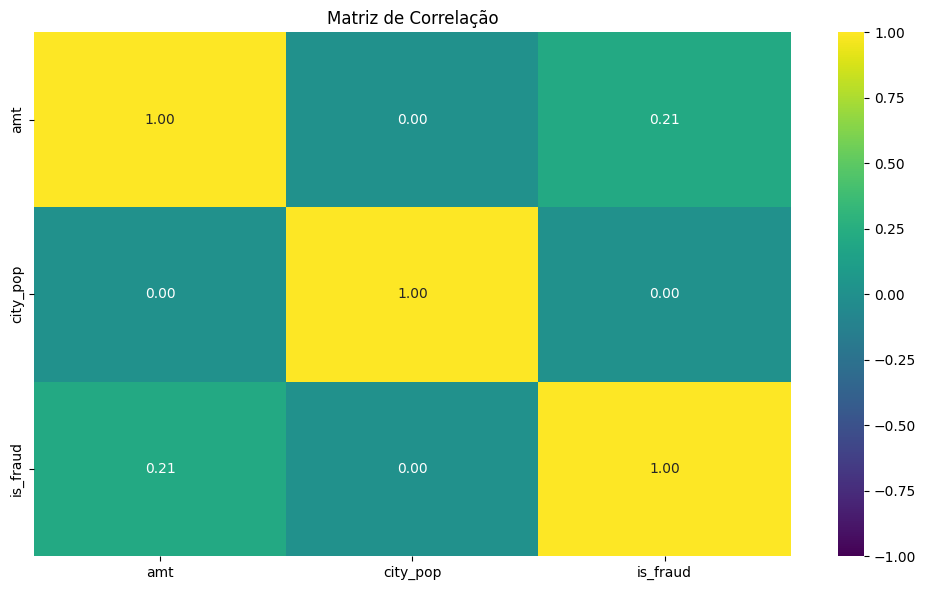

In [12]:
# Suprimir todos os warnings
warnings.filterwarnings("ignore")

# Criar a figura com 1 subgráfico (apenas o gráfico de correlação)
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

# 1. Gráfico de Correlação (Matriz de Correlação)
sns.heatmap(df_anl_num.corr(), annot=True, cmap="viridis", fmt=".2f", ax=axes, vmin=-1, vmax=1)
axes.set_title('Matriz de Correlação')

# Ajustar o layout
plt.tight_layout()
plt.show()


* Verificando relacao entre a variavel alvo e as variaveis explicativas categoricas ("frequencias")
    * Aqui ja podemos ver como se trata de um evento raro; 
    * as cateogrias de compras (variavel category) com "_net" sao de transacoes de compra online, as "_pos" sao trasacoes de compra presenciais. Elas detem a maioria das fraudes dentre as categorias, o que é naturalmente compreensivel. 

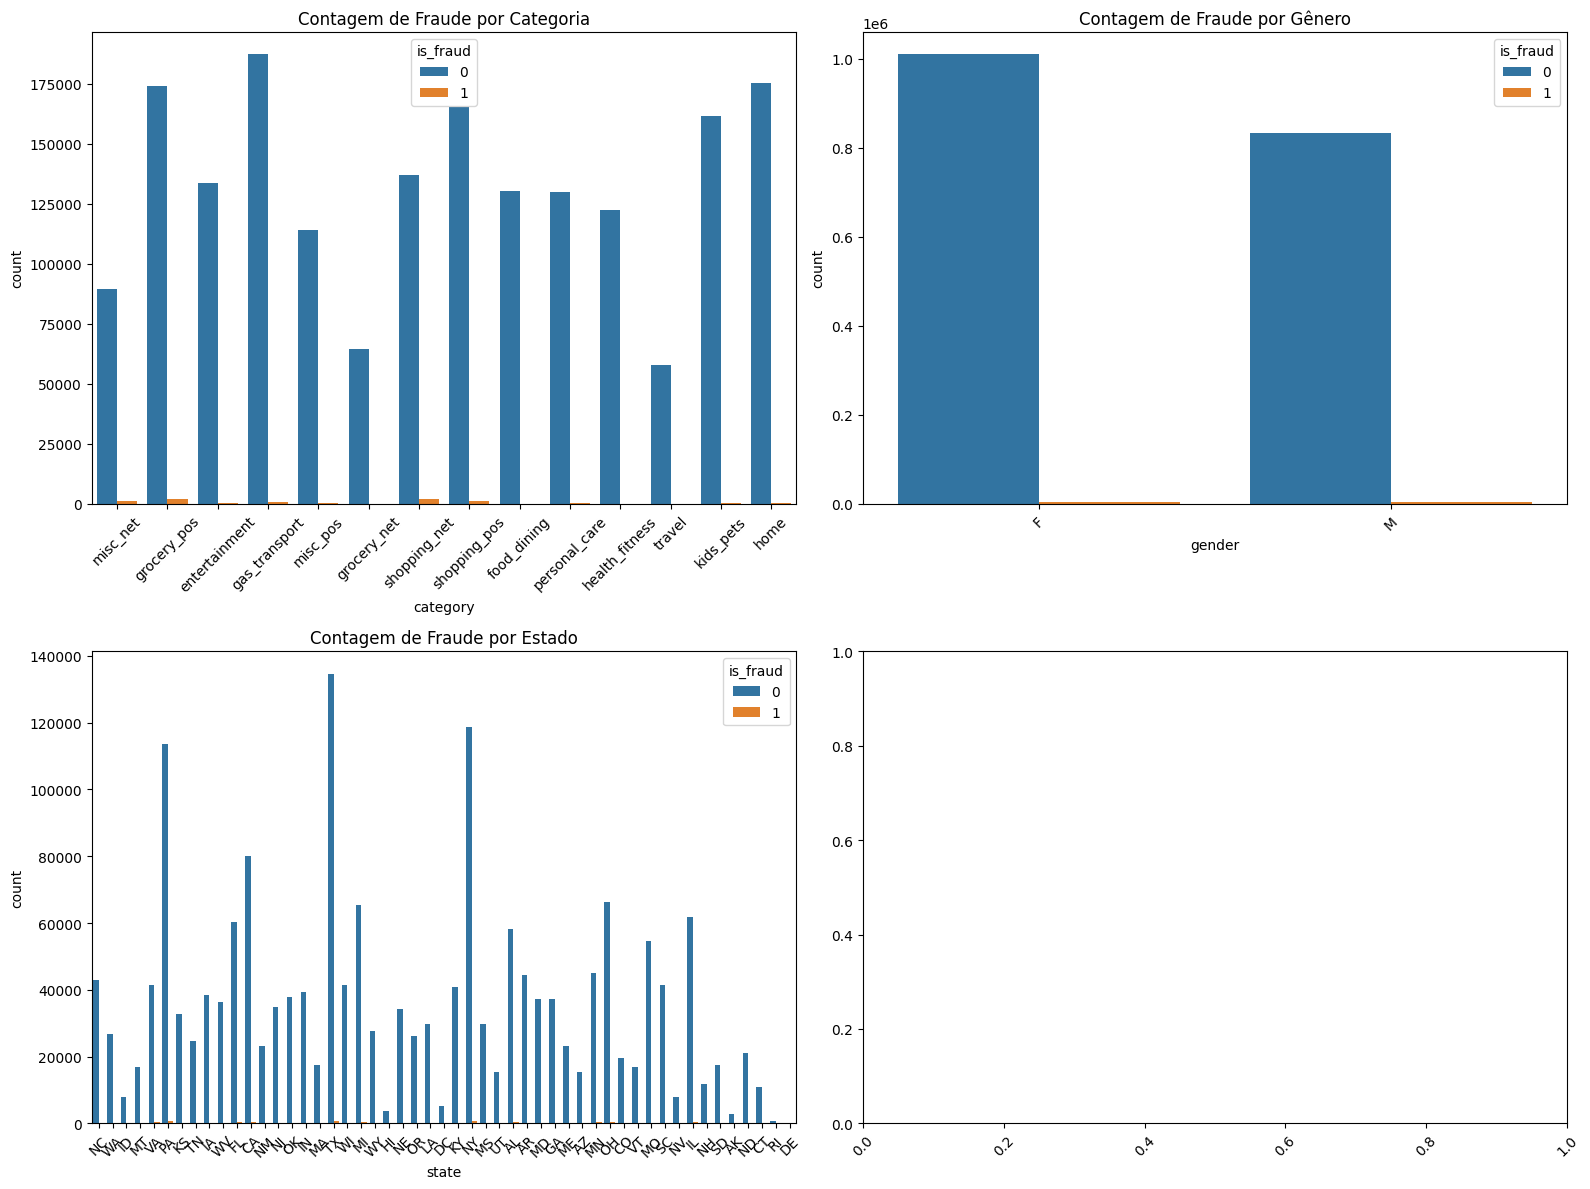

In [13]:
df_anl_cat = df_total[['category','gender','state','is_fraud']] #df so de categoricas elegiveis para analise (APENAS ANALISE)


# Criar a figura com 3 subgráficos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Gráfico de contagem para a variável 'category'
sns.countplot(data=df_anl_cat, x='category', hue='is_fraud', ax=axes[0, 0])
axes[0, 0].set_title('Contagem de Fraude por Categoria')

# 2. Gráfico de contagem para a variável 'gender'
sns.countplot(data=df_anl_cat, x='gender', hue='is_fraud', ax=axes[0, 1])
axes[0, 1].set_title('Contagem de Fraude por Gênero')

# 3. Gráfico de contagem para a variável 'state'
sns.countplot(data=df_anl_cat, x='state', hue='is_fraud', ax=axes[1, 0])
axes[1, 0].set_title('Contagem de Fraude por Estado')

# Aplicar rotação de 45 graus em todos os rótulos do eixo x
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)  # Rotaciona os rótulos do eixo x para 45 graus

# Ajustar layout
plt.tight_layout()

# Exibir o gráfico
plt.show()



* Verificando a relacao entre as variaveis numericas explicativas (sem variavel alvo)
    * Vemos um agrupamento em valores pequenos para ambas variaveis;
    * embora a variavel alvo esteja na legenda, é meramente para vermos onde se encontrar as observacoes de fraude entre as variaveis, nao e muito conclusivo mas da uma ideia de onde se "agrupam" em termos de valores

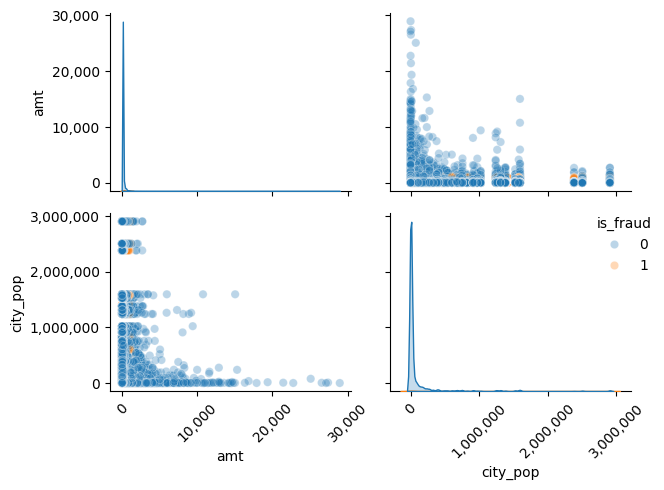

In [14]:
# Cria o pairplot
g = sns.pairplot(
    df_anl_num, 
    hue='is_fraud',
    diag_kind='kde',
    height=2.5,
    aspect=1.2,
    plot_kws={'alpha': 0.3}
)

# Formata os eixos 
for ax in g.axes.flatten():
    # Formatação(sem notação científica automatica)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.tick_params(axis='x', rotation=45) # eixo x em 45 graus

    plt.tight_layout()

plt.show()

* Verificando a relacao entre as variaveis explicativas categoricas (sem variavel alvo)
    * Aqui verificamos se ha associacao estatistica entre as variveis cetegoricas (sem a alvo) pelo teste de Qui2
    * Verificamos e classificamos em baixa media e alta a forca das associaicoes entre as variaveis categoricas, e plotamos os resultados pelo heatmap de V de Cramer tambem. 

Teste Qui-Quadrado entre category e gender:
Qui²=5407.24, p-valor=0.0000 (menor que 0.05, há evidência de associação).
V de Cramer=0.05 (Baixa Força de associação)

Teste Qui-Quadrado entre category e state:
Qui²=9421.63, p-valor=0.0000 (menor que 0.05, há evidência de associação).
V de Cramer=0.02 (Baixa Força de associação)

Teste Qui-Quadrado entre gender e category:
Qui²=5407.24, p-valor=0.0000 (menor que 0.05, há evidência de associação).
V de Cramer=0.05 (Baixa Força de associação)

Teste Qui-Quadrado entre gender e state:
Qui²=121239.38, p-valor=0.0000 (menor que 0.05, há evidência de associação).
V de Cramer=0.26 (Média Força de associação)

Teste Qui-Quadrado entre state e category:
Qui²=9421.63, p-valor=0.0000 (menor que 0.05, há evidência de associação).
V de Cramer=0.02 (Baixa Força de associação)

Teste Qui-Quadrado entre state e gender:
Qui²=121239.38, p-valor=0.0000 (menor que 0.05, há evidência de associação).
V de Cramer=0.26 (Média Força de associação)



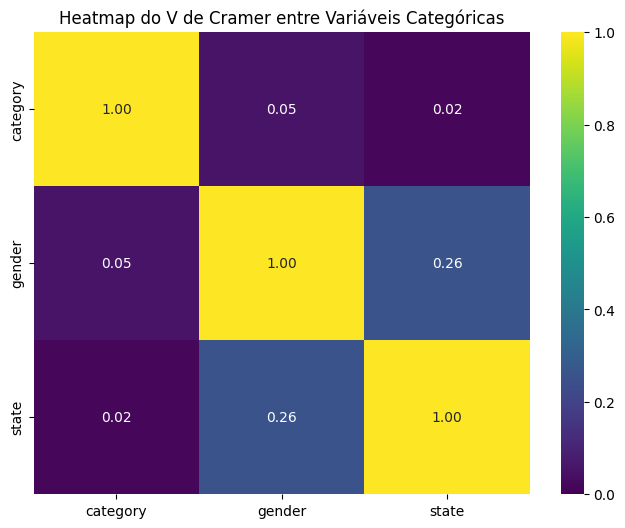

In [15]:
# df_ de categoricas sem a variavel alvo
df_cat = df_anl_cat[['category', 'gender', 'state']]

def cramers_v(x, y):
    """Calcula o V de Cramer entre duas variáveis categóricas."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Função para categorizar a força do V de Cramer
def categorize_cramers_v(value):
    if value < 0.10:
        return "Baixa Força de"
    elif value < 0.30:
        return "Média Força de"
    else:
        return "Alta Força de"

# Inicializa um DataFrame para armazenar os resultados
results = pd.DataFrame(index=df_cat.columns, columns=df_cat.columns)

for col1 in df_cat.columns:
    for col2 in df_cat.columns:
        if col1 == col2:
            results.loc[col1, col2] = 1.0  # Correlação perfeita com ela mesma
        else:
            table = pd.crosstab(df_cat[col1], df_cat[col2])
            chi2, p, _, _ = chi2_contingency(table)
            v_cramer = cramers_v(df_cat[col1], df_cat[col2])

            # Interpretação do p-valor
            significance = "há evidência de associação" if p < 0.05 else "não há evidência de associação"
            
            # Classificação da força do V de Cramer
            strength = categorize_cramers_v(v_cramer)

            print(f'Teste Qui-Quadrado entre {col1} e {col2}:')
            print(f'Qui²={chi2:.2f}, p-valor={p:.4f} ({"menor" if p < 0.05 else "maior"} que 0.05, {significance}).')
            print(f'V de Cramer={v_cramer:.2f} ({strength} associação)\n')

            results.loc[col1, col2] = v_cramer


# Converte os valores para float
results = results.astype(float)

plt.figure(figsize=(8, 6))
sns.heatmap(results, annot=True, cmap='viridis', fmt='.2f', vmin=0, vmax=1)
plt.title('Heatmap do V de Cramer entre Variáveis Categóricas')
plt.show()




* Aqui evidencia-se o desbalance das classes da variavel alvo, trata-se de um evento raro, conforme ja haviam indicios. 

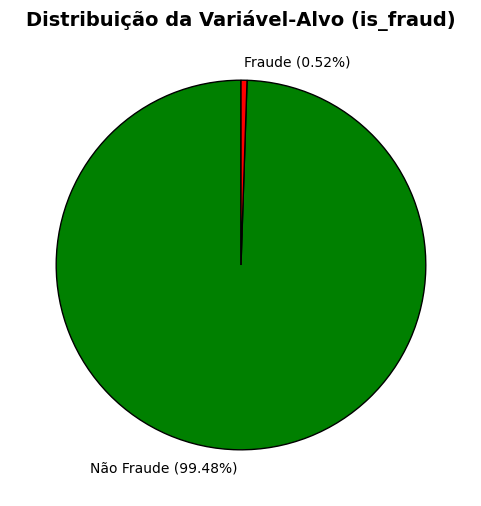

In [16]:
# Contar a quantidade de cada classe
fraud_counts = df_total["is_fraud"].value_counts()

# Criar o gráfico de pizza
plt.figure(figsize=(6, 6))
wedges, texts = plt.pie(
    fraud_counts, labels=["Não Fraude", "Fraude"], 
    colors=["green", "red"], startangle=90, wedgeprops={"edgecolor": "black"}
)

# Adicionar os percentuais como rótulos ao lado das fatias
for text, pct in zip(texts, fraud_counts / fraud_counts.sum() * 100):
    text.set_text(f"{text.get_text()} ({pct:.2f}%)")

# Adicionar título
plt.title("Distribuição da Variável-Alvo (is_fraud)", fontsize=14, fontweight="bold")

# Mostrar o gráfico
plt.show()


* Verificando localizacao das transacoes e dos titulares dos cartoes 
    * Aqui foi dado foco nos maiores ofensores de fraudes: as variaveis de compra presencial "_pos" e online "_net" pois apresentaram grande parte das fraudes 
    * Ha maior concentracao de transacoes do lado da Costa Leste 
    * Existem transacoes no Havai, Canadá e no Alasca, mas sao em pequenos volumes, ainda assim sao estranhas(principalemnte Alasca). 

In [17]:
# Filtrar apenas transações fraudulentas E que sejam online (_net)
df_fraude_net = df_total[(df_total["is_fraud"] == 1) & (df_total["category"].str.contains("_net", na=False))]

# Criar um DataFrame com as coordenadas SOMENTE de fraudes online
df_mapa = pd.DataFrame({
    "Latitude": list(df_fraude_net["lat"]) + list(df_fraude_net["merch_lat"]),
    "Longitude": list(df_fraude_net["long"]) + list(df_fraude_net["merch_long"]),
    "Tipo": ["Titular"] * len(df_fraude_net) + ["Estabelecimento"] * len(df_fraude_net)
})

# Amostrar 50% para evitar sobrecarga (ajuste conforme volume de dados)
df_mapa_sample = df_mapa.sample(frac=0.5, random_state=42) if len(df_mapa) > 1000 else df_mapa

# Criar o mapa com os pontos das fraudes online
fig = px.scatter_mapbox(df_mapa_sample, lat="Latitude", lon="Longitude",
                        color="Tipo",  
                        mapbox_style="carto-positron",
                        zoom=3, 
                        color_discrete_map={"Titular": "orange", "Estabelecimento": "blue"}  # Define cores personalizadas
                        )

# Ajustar layout com margem superior maior para exibir o título
fig.update_layout(
    width=1700,  
    height=700,  
    margin={"r":0, "t":50, "b":0, "l":0},
    title={
        "text": "AMOSTRA de Distribuição das Transações Fraudulentas ONLINE por Localização do Titular e Estabelecimento",
        "x": 0.5,  # Centraliza o título
        "xanchor": "center",  # Garante alinhamento centralizado
        "yanchor": "top",
        "font": {"size": 20, "family": "Arial Black"}  # Aumenta o tamanho e deixa em negrito
    }
)


fig.show()


In [18]:
# Filtrar apenas transações fraudulentas E que sejam presenciais (_pos)
df_fraude_net = df_total[(df_total["is_fraud"] == 1) & (df_total["category"].str.contains("_pos", na=False))]

# Criar um DataFrame com as coordenadas SOMENTE de fraudes presenciais
df_mapa = pd.DataFrame({
    "Latitude": list(df_fraude_net["lat"]) + list(df_fraude_net["merch_lat"]),
    "Longitude": list(df_fraude_net["long"]) + list(df_fraude_net["merch_long"]),
    "Tipo": ["Titular"] * len(df_fraude_net) + ["Estabelecimento"] * len(df_fraude_net)
})

# Amostrar 50% para evitar sobrecarga (ajuste conforme volume de dados)
df_mapa_sample = df_mapa.sample(frac=0.5, random_state=42) if len(df_mapa) > 1000 else df_mapa

# Criar o mapa com os pontos das fraudes presenciais, definindo cores específicas
fig = px.scatter_mapbox(df_mapa_sample, lat="Latitude", lon="Longitude",
                        color="Tipo",  
                        mapbox_style="carto-positron",
                        zoom=3,
                        color_discrete_map={"Titular": "orange", "Estabelecimento": "blue"}  # Define cores personalizadas
)

# Ajustar layout
fig.update_layout(
    width=1700,  
    height=700,  
    margin={"r":0, "t":50, "b":0, "l":0},
    title={
        "text": "AMOSTRA de Distribuição das Transações Fraudulentas PRESENCIAIS por Localização do Titular e Estabelecimento",
        "x": 0.5,  
        "xanchor": "center",  
        "yanchor": "top",
        "font": {"size": 20, "family": "Arial Black"}  
    }
)

fig.show()


# 3 Preparação dos Dados: Feature Engineering


* estudar a criacao de uma variavel que identifica a distancia (se e anormal) entre duas transacoes, acho que usar o racional da variavel de contagem de vezes que o cartao foi usado na ultima hora (trans_count_last_hour) 
ex: uma transacao feita presencialemnte seguida de outra presencialmente em locais muito distantes em 1 hora (ou outro periodo se for o caso) podem indicar uma possivel fraude

* criando variavel de distancia em Km entre estabeleciemnto e titular do cartao para compras presencias. 
    * Foi usada a distância entre os pontos pela fórmula de Haversine, pois ela considera a curvatura da Terra e retorna a distância real em km, diferentemente da Euclidiana, que assume um espaço plano (2D) e não converte diretamente em quilômetros.

In [19]:
# Função para remover variáveis desnecessarias
def Limpa_df(df, colunas_para_excluir):
    df = df.drop(columns=colunas_para_excluir, errors='ignore')  # ignora colunas que não existem
    #df = df.dropna()  # remove linhas com valores ausentes
    return df




def mover_target_para_final(df, target):
    """
    Move a variavel alvo para o final do df

    Isso nao interfere em resultados, e para manter o padrao de legibilidade e facilitar a visualizacao da target
    """
    colunas = [col for col in df.columns if col != target] + [target]
    return df[colunas]



In [20]:
# criando variavel de distancia em Km entre estabeleciemnto e titular do cartao para compras presencias (nao faz sentido para compras online que podem e muito provavlemente sera, bem distantes)
#essa variavel permitira entender se a compra presencial foi muito distante do local do titular do cartao, podendo indicar possivel fraude, isso sera estudado


# Definindo as categorias presenciais
categorias_presenciais = [
    "misc_pos", "grocery_pos", "gas_transport", 
    "shopping_pos", "personal_care", "health_fitness"
]


# Função para calcular distância Haversine em KM
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Raio médio da Terra em km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Aplicar linha a linha
df_total["distancia_km"] = df_total.apply(
    lambda row: haversine(row["lat"], row["long"], row["merch_lat"], row["merch_long"])
    if row["category"] in categorias_presenciais else np.nan,
    axis=1
)

#trata NAN 
df_total["distancia_km"] = df_total["distancia_km"].fillna(0)


df_total.head(10)





,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,distancia_km
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.08,-81.18,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.01,-82.05,0,0.00
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.89,-118.21,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.16,-118.19,0,30.21
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.18,-112.26,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.15,-112.15,0,0.00
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.23,-112.11,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.03,-112.56,0,95.67
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.42,-79.46,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.67,-78.63,0,77.56
5,2019-01-01 00:04:08,4767265376804500,"fraud_Stroman, Hudson and Erdman",gas_transport,94.63,Jennifer,Conner,F,4655 David Island,Dublin,PA,18917,40.38,-75.20,2158,Transport planner,1961-06-19,189a841a0a8ba03058526bcfe566aab5,1325376248,40.65,-76.15,0,85.92
6,2019-01-01 00:04:42,30074693890476,fraud_Rowe-Vandervort,grocery_net,44.54,Kelsey,Richards,F,889 Sarah Station Suite 624,Holcomb,KS,67851,37.99,-100.99,2691,Arboriculturist,1993-08-16,83ec1cc84142af6e2acf10c44949e720,1325376282,37.16,-100.15,0,0.00
7,2019-01-01 00:05:08,6011360759745864,fraud_Corwin-Collins,gas_transport,71.65,Steven,Williams,M,231 Flores Pass Suite 720,Edinburg,VA,22824,38.84,-78.60,6018,"Designer, multimedia",1947-08-21,6d294ed2cc447d2c71c7171a3d54967c,1325376308,38.95,-78.54,0,12.77
8,2019-01-01 00:05:18,4922710831011201,fraud_Herzog Ltd,misc_pos,4.27,Heather,Chase,F,6888 Hicks Stream Suite 954,Manor,PA,15665,40.34,-79.66,1472,Public affairs consultant,1941-03-07,fc28024ce480f8ef21a32d64c93a29f5,1325376318,40.35,-79.96,0,25.27
9,2019-01-01 00:06:01,2720830304681674,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,198.39,Melissa,Aguilar,F,21326 Taylor Squares Suite 708,Clarksville,TN,37040,36.52,-87.35,151785,Pathologist,1974-03-28,3b9014ea8fb80bd65de0b1463b00b00e,1325376361,37.18,-87.49,0,74.08


* Testando a distancia entre as variaveis em um mapa 
    * sugiro conferir em https://www.movable-type.co.uk/scripts/latlong.html tambem, para ter cereteza da logica de Haversine implantada (comparar os resultados da variavel de distancia pegando as coord e jogando la)

In [21]:
n_observacao=3 #deve ser observacao presencial as demais nao teram valor para essa variavel
# Selecionar a primeira observação do df_total
obs = df_total[df_total["cc_num"] == df_total["cc_num"].iloc[n_observacao]].iloc[0]

# Extrair coordenadas
lat1, lon1 = obs['lat'], obs['long']
lat2, lon2 = obs['merch_lat'], obs['merch_long']
distancia_km = obs['distancia_km']

# Criar DataFrame com os dois pontos
df_pontos = pd.DataFrame({
    'Nome': ['Titular', 'Estabelecimento'],
    'Latitude': [lat1, lat2],
    'Longitude': [lon1, lon2]
})

# Criar figura
fig = go.Figure()

# Adicionar os dois pontos
fig.add_trace(go.Scattermapbox(
    lat=df_pontos['Latitude'],
    lon=df_pontos['Longitude'],
    mode='markers+text',
    text=df_pontos['Nome'],
    marker=dict(size=12, color=['purple', 'blue']),
    textposition="top center",
    name='Pontos'
))

# Linha entre os pontos
fig.add_trace(go.Scattermapbox(
    lat=[lat1, lat2],
    lon=[lon1, lon2],
    mode='lines',
    line=dict(width=2, color='gray'),
    name='Distância reta'
))

# Ponto médio com rótulo da distância
if pd.notna(distancia_km):
    lat_meio = (lat1 + lat2) / 2
    lon_meio = (lon1 + lon2) / 2
    fig.add_trace(go.Scattermapbox(
        lat=[lat_meio],
        lon=[lon_meio],
        mode='markers+text',
        text=[f'{round(distancia_km, 2)} km'],
        marker=dict(size=1, color='white'),  # marcador minúsculo e invisível
        textfont=dict(size=14, color='black'),
        textposition="top center",
        showlegend=False
    ))

# Layout do mapa
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=3,
    mapbox_center={"lat": (lat1 + lat2) / 2, "lon": (lon1 + lon2) / 2},
    margin={"r":0,"t":0,"l":0,"b":0},
    height=500,
    title=f"Mapa: {obs['cc_num']} | Categoria: {obs['category']}"
)

fig.show()


* Verificando as quantidades por "categoria" (criada so pra analise, nao e uma feature) de distancias, para identificar concentracoes em distancias maiores para transacoes presenciais. 
    * Distancias muito grandes para compras presenciais e um estabelecimento "pode" pontar um padrao de fraudes;
    * Ha maior concentracao em fraudes presenciais de 50 a 100 km de distancia entre endereco do titular e o estabelecimento, e uma distancia aceitavel, pode significar viagens, trabalho ... Nada muito discrepante. 
    * Ha poucas variaveis com km acima de 120, nao parecem ser indcios de padrao de fraude. 

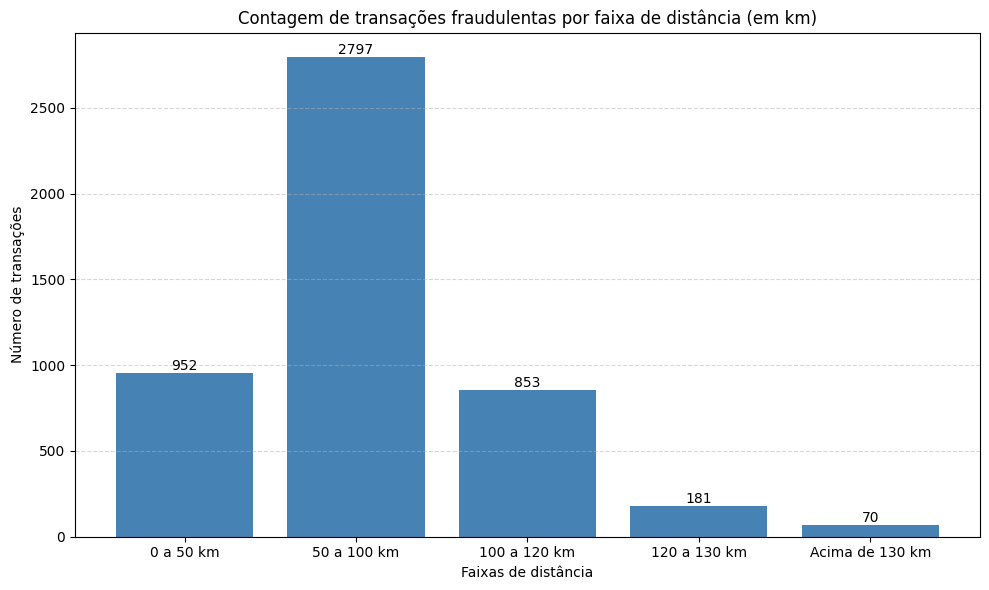

Total de transações fraudulentas com distância >= 0 km: 9651


In [22]:
import matplotlib.pyplot as plt

# Contagens por faixa
faixas = ['0 a 50 km', '50 a 100 km', '100 a 120 km', '120 a 130 km', 'Acima de 130 km']
contagens = [
    ((df_total["distancia_km"] > 0) & (df_total["distancia_km"] <= 50) & (df_total["is_fraud"] == 1)).sum(),
    ((df_total["distancia_km"] > 50) & (df_total["distancia_km"] <= 100) & (df_total["is_fraud"] == 1)).sum(),
    ((df_total["distancia_km"] > 100) & (df_total["distancia_km"] <= 120) & (df_total["is_fraud"] == 1)).sum(),
    ((df_total["distancia_km"] > 120) & (df_total["distancia_km"] <= 130) & (df_total["is_fraud"] == 1)).sum(),
    ((df_total["distancia_km"] > 130) & (df_total["is_fraud"] == 1)).sum()
]

# Plotando o gráfico
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.bar(faixas, contagens, color='steelblue')

# Adicionando rótulos com as contagens
for bar, count in zip(bars, contagens):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(count), 
             ha='center', va='bottom', fontsize=10)

plt.title('Contagem de transações fraudulentas por faixa de distância (em km)')
plt.ylabel('Número de transações')
plt.xlabel('Faixas de distância')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


print("Total de transações fraudulentas com distância >= 0 km:", 
      ((df_total["is_fraud"] == 1) & (df_total["distancia_km"] >= 0)).sum())




In [23]:
# Copia a coluna de trans_num para preserva-la comom coluna de dados no df 
df_total["trans_num_copy"] = df_total["trans_num"]

# Define o índice como trans_num 
df_total.set_index("trans_num_copy", inplace=True)


In [24]:
df_total.index.name = None #tira o cabecalho da variavel trans_num da primeira linha do df

In [25]:
# Dropando colunas desnecessarias
colunas_excluir = ['unix_time', 'zip', 'state', 'city', 'street', 'gender', 'last', 'first','job','merchant']
df_total = Limpa_df(df_total, colunas_excluir)

In [26]:
#transformar variaveis com transformacao relevante (inicialmente) no dicionario de dados CONTINUAR

# Converter 'dob' e 'trans_date...' para datetime
df_total["dob"] = pd.to_datetime(df_total["dob"])
df_total["trans_date_trans_time"] = pd.to_datetime(df_total["trans_date_trans_time"])

#calculando a idade
#usando a diferenca entre o nascimento e o momento da transacao para evitar distorcoes (usar a data atual criaria uma idade flutuante ao longo do tempo)
df_total["age"] = df_total.apply(lambda linha: linha["trans_date_trans_time"].year - linha["dob"].year, axis=1) #funcao lambda "linha" que aplica a subtracao de datas linha a linha no df_total atraves do apply()

#remove data de nascimento, nao e mais util
df_total.drop(columns=["dob"], inplace=True)


In [27]:
# criando variavel 'BIN' que corresponde ao codigo do banco da transacao com base no numero do cartao 'cc_num'
df_total["bin"] = df_total["cc_num"].astype(str).str[:6]

In [28]:
# extraindo variaveis do horario da transacao

# Certificando que a coluna 'trans_date_trans_time' está no formato datetime
df_total['trans_date_trans_time'] = pd.to_datetime(df_total['trans_date_trans_time'])

# Extraindo o dia da semana (0=segunda, 1=terça, ..., 6=domingo)
df_total['day_of_week'] = df_total['trans_date_trans_time'].dt.dayofweek

# Extraindo o mês
df_total['month'] = df_total['trans_date_trans_time'].dt.month

# Extraindo o horário completo (hora:minuto:segundo)
df_total['time'] = df_total['trans_date_trans_time'].dt.strftime('%H:%M:%S')


def classify_period(hour):
    if 0 <= hour < 3:
        return 'Madrugada Início'
    elif 3 <= hour < 6:
        return 'Madrugada Final'
    elif 6 <= hour < 9:
        return 'Manhã Início'
    elif 9 <= hour < 12:
        return 'Manhã Final'
    elif 12 <= hour < 15:
        return 'Tarde Início'
    elif 15 <= hour < 18:
        return 'Tarde Final'
    elif 18 <= hour < 21:
        return 'Noite Início'
    elif 21 <= hour < 24:
        return 'Noite Final'


# Extraindo a hora da transação
df_total['hour'] = df_total['trans_date_trans_time'].dt.hour

# Aplicando a função para classificar o período
df_total['period'] = df_total['hour'].apply(classify_period)


In [29]:
#VARAIVEL DE CONTAGEM DE VEZES QUE O CARTAO FOI USADO NAS ULTIMAS 1 HORA 
# (PRECISA INVESTIGAR SE 1 HORA E MUITO OU POUCO PARA ESSA VARIAVEL, A IDEIA E PEGAR O PADRAO DE TEMPO ENTRE UMA E OUTRA TRANSACAO FRAUDULENTA)

# Converter para datetime e ordenar
df_total['trans_date_trans_time'] = pd.to_datetime(df_total['trans_date_trans_time'])
df_total = df_total.sort_values(by=['trans_date_trans_time', 'cc_num'])

# Resetar o índice temporariamente para permitir o uso com numpy (evita erro com string como índice)
df_total_reset = df_total.reset_index()  # trans_num vira coluna

# Criar array para armazenar a contagem
trans_count_list = np.zeros(len(df_total_reset), dtype=int)

# Aplicar a contagem eficiente usando searchsorted()
for card, group in df_total_reset.groupby('cc_num'):
    timestamps = group['trans_date_trans_time'].values
    idx = np.searchsorted(timestamps, timestamps - np.timedelta64(1, 'h'), side='left')
    trans_count_list[group.index] = np.arange(len(group)) - idx

# Atribuir os valores ao DataFrame
df_total_reset['trans_count_last_hour'] = trans_count_list

# Restaurar o índice original 'trans_num'
df_total = df_total_reset.set_index('trans_num')



#validando logica (comparar as horas entre as transacoes e se a quantidade bate)
#df_filtro = df_total[df_total['cc_num'] == 	4613314721966]
#df_filtro = df_filtro[df_filtro['is_fraud'] == 1	]

#df_filtro = df_filtro.sort_values(by='trans_date_trans_time', ascending=False)  # Ordenar do maior para o menor

#df_filtro.head(1000)



In [30]:
#VARIAVEL DE QUANTIDADE DE VEZES QUE O CARTAO DE CADA TRANSACAO FOI USADO DURANTE PERIODO TOTAL (AMOSTRA INTEIRA)

# Contar quantas vezes cada cartão aparece na base
df_qtd_uso_cartoes = df_total.groupby('cc_num').size().reset_index(name='card_usage_count')

# Juntar essa informação de volta ao DataFrame original
df_total = df_total.merge(df_qtd_uso_cartoes, on='cc_num', how='left')


#validando logica
#df_filtro_uso = df_qtd_uso_cartoes[df_qtd_uso_cartoes['cc_num']==4613314721966]
#df_filtro_uso.head(10)

# Define o índice novamente (foi desconfigurado nos processos anteriores por necessidade)
df_total.set_index("index", inplace=True)

df_total.index.name = None #tira o cabecalho da variavel da primeira linha do df


#Aplica def de reorganizar colunas 
df_total = mover_target_para_final(df_total, 'is_fraud')

# Transformação de Horário em Variáveis Cíclicas (Seno e Cosseno)

A variável time, que representa o horário da transação, possui natureza cíclica, ou seja, após 23:59 o ciclo recomeça em 00:00. Modelos de Machine Learning não entendem esse padrão circular por padrão, e tratam 23h e 0h como distantes, quando na verdade são muito próximas.

Para capturar essa ciclicidade corretamente, transformamos a hora em duas novas variáveis usando funções trigonométricas:

time_sin = sin(2π * hora / 24)

time_cos = cos(2π * hora / 24)

Essas variáveis projetam o horário em um círculo unitário, permitindo que o modelo entenda a transição natural entre horários e aprenda padrões temporais com mais precisão.

Essa técnica é especialmente útil em modelos lineares, onde relações cíclicas não são captadas automaticamente.

In [31]:

# Converter a coluna 'time' de string para datetime.time
df_total['time'] = pd.to_datetime(df_total['time'], format='%H:%M:%S').dt.time

# Extrair a hora, minuto e segundo como número decimal de hora
df_total['hora_decimal'] = df_total['time'].apply(lambda x: x.hour + x.minute/60 + x.second/3600)

# Codificação cíclica: seno e cosseno da hora do dia
df_total['time_sin'] = np.sin(2 * np.pi * df_total['hora_decimal'] / 24)
df_total['time_cos'] = np.cos(2 * np.pi * df_total['hora_decimal'] / 24)



#dropando variavel 'time' apos transformaca, caso ela seja necessaia para calcular o tempo entre trnasacoes (se essa variavel for viabilizada, esta em analise se faz sentido) 
#basta comentar essa parte do codigo que ela se mantem 

# Dropando colunas desnecessarias
colunas_excluir = ['time']
df_total = Limpa_df(df_total, colunas_excluir)


#visualizando nova feature
pd.set_option('display.max_rows', None)
df_total.head(10)

,trans_date_trans_time,cc_num,category,amt,lat,long,city_pop,merch_lat,merch_long,distancia_km,age,bin,day_of_week,month,hour,period,trans_count_last_hour,card_usage_count,is_fraud,hora_decimal,time_sin,time_cos
0b242abb623afc578575680df30655b9,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,36.08,-81.18,3495,36.01,-82.05,0.00,31,270318,1,1,0,Madrugada Início,0,2927,0,0.01,0.00,1.00
1f76529f8574734946361c461b024d99,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,48.89,-118.21,149,49.16,-118.19,30.21,41,630423,1,1,0,Madrugada Início,0,4362,0,0.01,0.00,1.00
a1a22d70485983eac12b5b88dad1cf95,2019-01-01 00:00:51,38859492057661,entertainment,220.11,42.18,-112.26,4154,43.15,-112.15,0.00,57,388594,1,1,0,Madrugada Início,0,735,0,0.01,0.00,1.00
6b849c168bdad6f867558c3793159a81,2019-01-01 00:01:16,3534093764340240,gas_transport,45.00,46.23,-112.11,1939,47.03,-112.56,95.67,52,353409,1,1,0,Madrugada Início,0,743,0,0.02,0.01,1.00
a41d7549acf90789359a9aa5346dcb46,2019-01-01 00:03:06,375534208663984,misc_pos,41.96,38.42,-79.46,99,38.67,-78.63,77.56,33,375534,1,1,0,Madrugada Início,0,2922,0,0.05,0.01,1.00
189a841a0a8ba03058526bcfe566aab5,2019-01-01 00:04:08,4767265376804500,gas_transport,94.63,40.38,-75.20,2158,40.65,-76.15,85.92,58,476726,1,1,0,Madrugada Início,0,736,0,0.07,0.02,1.00
83ec1cc84142af6e2acf10c44949e720,2019-01-01 00:04:42,30074693890476,grocery_net,44.54,37.99,-100.99,2691,37.16,-100.15,0.00,26,300746,1,1,0,Madrugada Início,0,2933,0,0.08,0.02,1.00
6d294ed2cc447d2c71c7171a3d54967c,2019-01-01 00:05:08,6011360759745864,gas_transport,71.65,38.84,-78.60,6018,38.95,-78.54,12.77,72,601136,1,1,0,Madrugada Início,0,1464,0,0.09,0.02,1.00
fc28024ce480f8ef21a32d64c93a29f5,2019-01-01 00:05:18,4922710831011201,misc_pos,4.27,40.34,-79.66,1472,40.35,-79.96,25.27,78,492271,1,1,0,Madrugada Início,0,1470,0,0.09,0.02,1.00
3b9014ea8fb80bd65de0b1463b00b00e,2019-01-01 00:06:01,2720830304681674,grocery_pos,198.39,36.52,-87.35,151785,37.18,-87.49,74.08,45,272083,1,1,0,Madrugada Início,0,1467,0,0.10,0.03,1.00


* verificando os tipos das variaveis e a contagem de categorias das categoricas 
    * das 3 categoricas e possivel notar que a vartaivel bin que corresponde ao codigo do suposto banco de cada transacao, tem muitas categorias (muitos bancos) isso torna inviavel one hot encoder
    * Entao na celula seguinte, foi verificado dos bancos mais ofensores em percentual de fraudes por transacao, para encontrar algum padrao 
    * Dado isso, será aplicada uma transformação de Target Encoding (neste caso, Mean Encoding), que substitui cada categoria de bin pela média do target (proporção média de fraude) dentro daquela categoria. 
        * Para evitar overfitting e vazamento de dados, a codificação será aplicada separadamente dentro de cada fold durante a validação cruzada e, posteriormente, no conjunto de teste de forma independente. 
        * Além disso, será utilizado o parâmetro smoothing, que atua como uma forma de regularização. O smoothing realiza um balanceamento entre a média do target por categoria e a média global do target, dando mais peso à média global em categorias com poucas observações. Isso ajuda a suavizar os valores atribuídos a categorias raras e reduz o risco de superestimar seu efeito, tornando o modelo mais robusto.

In [32]:

# VERIFICANDO OS TIPOS PARA POSSIVEL TRANSFORMACAO 
print(df_total.dtypes)

print('')
# Selecionar colunas do tipo object
object_cols = df_total.select_dtypes(include='object').columns

# Contar categorias únicas em cada uma
for col in object_cols:
    print(f"{col}: {df_total[col].nunique()} categorias únicas")



trans_date_trans_time    datetime64[ns]
cc_num                            int64
category                         object
amt                             float64
lat                             float64
long                            float64
city_pop                          int64
merch_lat                       float64
merch_long                      float64
distancia_km                    float64
age                               int64
bin                              object
day_of_week                       int32
month                             int32
hour                              int32
period                           object
trans_count_last_hour             int64
card_usage_count                  int64
is_fraud                          int64
hora_decimal                    float64
time_sin                        float64
time_cos                        float64
dtype: object

category: 14 categorias únicas
bin: 976 categorias únicas
period: 8 categorias únicas


In [33]:
# Agrupamento por bin com os principais indicadores
resumo_bin = (
    df_total
    .groupby('bin')
    .agg(
        proporcao_fraude=('is_fraud', 'mean'),
        contagem_fraude=('is_fraud', 'sum'),
        total_transacoes=('is_fraud', 'count')
    )
    .reset_index()
    .sort_values(by='proporcao_fraude', ascending=False)
)

# Auemntar para uns 100 para ver a quebra dos bancos mais ofensores em percentual
resumo_bin.head(10) 


,bin,proporcao_fraude,contagem_fraude,total_transacoes
27,180098,1.00,12,12
4,180020,1.00,12,12
26,180097,1.00,7,7
7,180038,1.00,10,10
960,676179,1.00,11,11
259,352804,1.00,11,11
603,441767,1.00,11,11
299,354733,1.00,11,11
283,354041,1.00,8,8
922,651777,1.00,11,11


# Aplicar a selecao de fatures por importancia antes do modelo (CONTINUAR)

In [34]:
#################################################

# Modelagem (separar um pouco essa fase, aqui tem separacao de treino e teste, optuna, aplicao final... separa para nao ficar pesada a leitura e correcoes, tipo modularizar mesmo)

* estudar a criacao de uma variavel que identifica a distancia (se e anormal) entre duas transacoes, acho que usar o racional da variavel de contagem de vezes que o cartao foi usado na ultima hora (trans_count_last_hour) 
ex: uma transacao feita presencialemnte seguida de outra presencialmente em locais muito distantes em 1 hora (ou outro periodo se for o caso) podem indicar uma possivel fraude

In [ ]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
import optuna
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef


# ====================
# 1. Split em treino e teste
# ====================
X = df_total.drop('is_fraud', axis=1)
y = df_total['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Junta X_train e y_train para uso no Optuna
df_train = X_train.copy()
df_train['is_fraud'] = y_train

target = 'is_fraud'

# ====================
# 2. Target Encoding
# ====================
def apply_target_encoding(train, val_or_test, col, target, smoothing=15):
    global_mean = train[target].mean()
    stats = train.groupby(col)[target].agg(['mean', 'count'])
    smooth = (stats['mean'] * stats['count'] + global_mean * smoothing) / (stats['count'] + smoothing)
    encoded_col = val_or_test[col].map(smooth).fillna(global_mean)
    return encoded_col


# ====================
# 3. Transformações de Colunas
# ====================
# One-Hot Encoding para colunas categóricas
def fit_transform_ohe(train_df, val_df, col):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    train_encoded = ohe.fit_transform(train_df[[col]])
    val_encoded = ohe.transform(val_df[[col]])

    train_ohe = pd.DataFrame(train_encoded, columns=[f"{col}_{cat}" for cat in ohe.categories_[0]], index=train_df.index)
    val_ohe = pd.DataFrame(val_encoded, columns=[f"{col}_{cat}" for cat in ohe.categories_[0]], index=val_df.index)

    return train_ohe, val_ohe, ohe

# Colunas categóricas e contínuas
categorical_features = ['category', 'period']
numeric_features = [col for col in X_train.columns if col not in categorical_features]


# ====================
# 4. Pipeline de Pré-processamento
# ====================
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline([
            ('target_encoding', apply_target_encoding),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ]
)


# ====================
# 5. Otimização com Optuna
# ====================

#variaveis Globais 
threshold = 0.5

n_trials_= 10

n_splits_ = 5

weights_skf = {
    'Accuracy': 0.00,
    'f1': 0.15,
    'precision': 0.00,
    'recall': 0.70,
    'auc': 0.15,
    'balanced_acc': 0.0,
    'mcc': 0.00
}


def generate_folds_and_train(trial, df_train, target, n_splits=n_splits_):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metric_sums = {
        'Accuracy': 0,
        'f1': 0,
        'precision': 0,
        'recall': 0,
        'auc': 0,
        'balanced_acc': 0,
        'mcc': 0
    }

    for train_idx, val_idx in skf.split(df_train, df_train[target]):
        train_fold = df_train.iloc[train_idx].copy()
        val_fold = df_train.iloc[val_idx].copy()

        # ====== Target Encoding ======
        train_fold['bin_target_enc'] = apply_target_encoding(train_fold, train_fold, 'bin', target)
        val_fold['bin_target_enc'] = apply_target_encoding(train_fold, val_fold, 'bin', target)

        # OneHot Encoding nas colunas 'category' e 'period'
        train_ohe_cat, val_ohe_cat, _ = fit_transform_ohe(train_fold, val_fold, 'category')
        train_ohe_period, val_ohe_period, _ = fit_transform_ohe(train_fold, val_fold, 'period')

        # ====== Features Finais ======
        X_train = pd.concat([train_fold[['bin_target_enc']], train_ohe_cat, train_ohe_period], axis=1)
        X_val = pd.concat([val_fold[['bin_target_enc']], val_ohe_cat, val_ohe_period], axis=1)

        # ====== Scaling ======
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        y_train = train_fold[target]
        y_val = val_fold[target]

        # Calcula scale_pos_weight com base no desequilíbrio (para cada fold e feito o mesmo no treianmetno final se alterar la tem que altera aqui e vice versa )
        neg, pos = np.bincount(y_train)
        scale_pos_weight = neg / pos

        # Modelo
        model = XGBClassifier(
            objective='binary:logistic',
            tree_method='gpu_hist',  # ou 'hist' se não usar GPU
            use_label_encoder=False,
            eval_metric='logloss',
            n_estimators=trial.suggest_int("n_estimators", 50, 1000),
            max_depth=trial.suggest_int("max_depth", 2, 15),
            learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
            gamma=trial.suggest_float("gamma", 0, 5),
            reg_alpha=trial.suggest_float("reg_alpha", 0, 5),
            reg_lambda=trial.suggest_float("reg_lambda", 0, 5),
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1
        )


        model.fit(X_train_scaled, y_train)
        probs = model.predict_proba(X_val_scaled)[:, 1]
        preds = (probs >= 0.5).astype(int)

        # ====== MÉTRICAS ======
        metric_sums['Accuracy']     += accuracy_score(y_val, preds)
        metric_sums['f1']           += f1_score(y_val, preds)
        metric_sums['precision']    += precision_score(y_val, preds, zero_division=0)
        metric_sums['recall']       += recall_score(y_val, preds)
        metric_sums['auc']          += roc_auc_score(y_val, probs)
        metric_sums['balanced_acc'] += balanced_accuracy_score(y_val, preds)
        metric_sums['mcc']          += matthews_corrcoef(y_val, preds)

    # Média das métricas
    mean_metrics = {k: v / n_splits for k, v in metric_sums.items()}
    final_score = sum(mean_metrics[k] * weights_skf[k] for k in weights_skf)

    return final_score


# ====================
# 6. Optuna - Otimização
# ====================


#variaveis globais 

def objective(trial):
    return generate_folds_and_train(trial, df_train, target)


sampler_ = optuna.samplers.TPESampler(n_startup_trials=15, 
                                      n_ei_candidates=30, 
                                      group=True,seed=42,
                                      multivariate=True)

study = optuna.create_study(direction='maximize', sampler=sampler_, pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(), patience=15))
study.optimize(objective, n_trials=n_trials_)  
best_params = study.best_params

# Melhores hiperparâmetros
print("📊 MELHORES HIPERPARÂMETROS ENCONTRADOS")
print("═" * 60)
for param, value in best_params.items():
    print(f"{param:<25}{value:<15}")
print("═" * 60)




from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# ===========================
# 1. Transforma o X_test com base no df_train completo
# ===========================
def apply_encoding_and_scaling(df_train, df_test, target):
    df_test_transformed = df_test.copy()

    # Target Encoding
    df_test_transformed['bin_target_enc'] = apply_target_encoding(df_train, df_test_transformed, 'bin', target)

    # One Hot Encoding
    _, test_ohe_category, _ = fit_transform_ohe(df_train, df_test_transformed, 'category')
    _, test_ohe_period, _ = fit_transform_ohe(df_train, df_test_transformed, 'period')

    X_test = pd.concat([df_test_transformed[['bin_target_enc']], test_ohe_category, test_ohe_period], axis=1)

    # Treina transformação no df_train completo
    df_train_transf = df_train.copy()
    df_train_transf['bin_target_enc'] = apply_target_encoding(df_train, df_train, 'bin', target)
    _, train_ohe_category, _ = fit_transform_ohe(df_train, df_train, 'category')
    _, train_ohe_period, _ = fit_transform_ohe(df_train, df_train, 'period')

    X_train_transf = pd.concat([df_train_transf[['bin_target_enc']], train_ohe_category, train_ohe_period], axis=1)

    # Escalador treinado no X_train completo
    scaler = StandardScaler()
    scaler.fit(X_train_transf)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = scaler.transform(X_train_transf)

    return X_train_scaled, X_test_scaled, df_train[target]

# ===========================
# 2. Transforma treino e teste
# ===========================
X_train_final, X_test_final, y_train_final = apply_encoding_and_scaling(df_train, X_test, target)

# ===========================
# 3. Treina o modelo final com os melhores parâmetros do Optuna
# ===========================

neg, pos = np.bincount(y_train_final)
scale_pos_weight = neg / pos


model_final = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    tree_method='gpu_hist'  # ou 'hist' se não for usar GPU
)

model_final.fit(X_train_final, y_train_final)

# ===========================
# 4. Gera a predição no treino
# ===========================
y_train_pred_proba = model_final.predict_proba(X_train_final)[:, 1]

# ===========================
# 5. Predição no conjunto de teste
# ===========================
y_test_pred_proba = model_final.predict_proba(X_test_final)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"ROC AUC no conjunto de teste: {roc_auc:.4f}")



[I 2025-04-06 03:21:13,665] A new study created in memory with name: no-name-c2fb98d7-76fd-4181-82be-d5ab72db6a7b


In [ ]:
def avaliar_modelo(y_train_true, y_train_proba, y_test_true, y_test_proba, threshold=threshold):
    """
    Avalia o desempenho de um modelo de classificação binária com curvas ROC e Precision-Recall.

    Parâmetros:
        y_train_true (array-like): Valores reais do conjunto de treino.
        y_train_proba (array-like): Probabilidades previstas no treino.
        y_test_true (array-like): Valores reais do conjunto de teste.
        y_test_proba (array-like): Probabilidades previstas no teste.
        threshold (float): Limite para converter probabilidades em classes (default=0.5).
    """
    from sklearn.metrics import (
        roc_curve, roc_auc_score,
        precision_recall_curve,
        confusion_matrix, ConfusionMatrixDisplay,
        accuracy_score, precision_score, recall_score, f1_score
    )
    import matplotlib.pyplot as plt

    # Predição binária com threshold
    y_test_pred = (y_test_proba >= threshold).astype(int)

    # ===== CURVA ROC - Treino e Teste =====
    fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_proba)
    auc_train = roc_auc_score(y_train_true, y_train_proba)
    auc_test = roc_auc_score(y_test_true, y_test_proba)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr_train, tpr_train, label=f"Treino (AUC = {auc_train:.2f})", color="blue")
    plt.plot(fpr_test, tpr_test, label=f"Teste (AUC = {auc_test:.2f})", color="darkorange")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC - Treino vs Teste")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # ===== PRECISION vs RECALL =====
    precision, recall, thresholds = precision_recall_curve(y_test_true, y_test_proba)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color="green", lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision vs Recall Curve (Teste)")
    plt.grid(True)
    plt.show()

    # ===== MATRIZ DE CONFUSÃO (Teste) =====
    cm = confusion_matrix(y_test_true, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Matriz de Confusão (Teste)")
    plt.show()

    # ===== MÉTRICAS BINÁRIAS (Teste) =====
    accuracy = accuracy_score(y_test_true, y_test_pred)
    precision_val = precision_score(y_test_true, y_test_pred, zero_division=0)
    recall_val = recall_score(y_test_true, y_test_pred)
    f1 = f1_score(y_test_true, y_test_pred)

    print("==== MÉTRICAS DE TESTE ====")
    print(f"Acurácia:  {accuracy:.4f}")
    print(f"Precisão:  {precision_val:.4f}")
    print(f"Recall:    {recall_val:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC AUC:   {auc_test:.4f}")




#chamndo funcao de avaliar modelo com as metricas 

avaliar_modelo(y_train, y_train_pred_proba, y_test, y_test_pred_proba, threshold=threshold)